In [11]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import numpy as np
import itertools  
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
from keras import layers
from keras.models import Model

def _after_conv(in_tensor):
    norm = layers.BatchNormalization()(in_tensor)
    return layers.Activation('relu')(norm)

def conv1(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=1)(in_tensor)
    return _after_conv(conv)

def conv1_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=2)(in_tensor)
    return _after_conv(conv)

def conv3(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(in_tensor)
    return _after_conv(conv)

def conv3_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(in_tensor)
    return _after_conv(conv)

def resnet_block_wo_bottlneck(in_tensor, filters, downsample=False):
    if downsample:
        conv1_rb = conv3_downsample(in_tensor, filters)
    else:
        conv1_rb = conv3(in_tensor, filters)
    conv2_rb = conv3(conv1_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    result = layers.Add()([conv2_rb, in_tensor])

    return layers.Activation('relu')(result)

def resnet_block_w_bottlneck(in_tensor,
                             filters,
                             downsample=False,
                             change_channels=False):
    if downsample:
        conv1_rb = conv1_downsample(in_tensor, int(filters/4))
    else:
        conv1_rb = conv1(in_tensor, int(filters/4))
    conv2_rb = conv3(conv1_rb, int(filters/4))
    conv3_rb = conv1(conv2_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    elif change_channels:
        in_tensor = conv1(in_tensor, filters)
    result = layers.Add()([conv3_rb, in_tensor])

    return result

def _pre_res_blocks(in_tensor):
    conv = layers.Conv2D(64, 7, strides=2, padding='same')(in_tensor)
    conv = _after_conv(conv)
    pool = layers.MaxPool2D(3, 2, padding='same')(conv)
    return pool

def _post_res_blocks(in_tensor, n_classes):
    pool = layers.GlobalAvgPool2D()(in_tensor)
    preds = layers.Dense(n_classes, activation='softmax')(pool)
    return preds

def convx_wo_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_wo_bottlneck(res, filters, downsample_1)
        else:
            res = resnet_block_wo_bottlneck(res, filters)
    return res

def convx_w_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_w_bottlneck(res, filters, downsample_1, not downsample_1)
        else:
            res = resnet_block_w_bottlneck(res, filters)
    return res

def _resnet(in_shape=(256,256,3),
            n_classes=3,
            opt='sgd',
            convx=[128, 256, 512, 1024],
            n_convx=[2, 2, 2, 2],
            convx_fn=convx_wo_bottleneck):
    in_layer = layers.Input(in_shape)

    downsampled = _pre_res_blocks(in_layer)

    conv2x = convx_fn(downsampled, convx[0], n_convx[0])
    conv3x = convx_fn(conv2x, convx[1], n_convx[1], True)
    conv4x = convx_fn(conv3x, convx[2], n_convx[2], True)
    conv5x = convx_fn(conv4x, convx[3], n_convx[3], True)

    preds = _post_res_blocks(conv5x, n_classes)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
	              metrics=["accuracy"])
    return model

def resnet18(in_shape=(256,256,3), n_classes=3, opt='sgd'):
    return _resnet(in_shape, n_classes, opt)

def resnet34(in_shape=(256,256,3), n_classes=3, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  n_convx=[3, 4, 6, 3])

def resnet50(in_shape=(256,256,3), n_classes=3, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  [256, 512, 1024, 2048],
                  [3, 4, 6, 3],
                  convx_w_bottleneck)

def resnet101(in_shape=(256,256,3), n_classes=3, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  [256, 512, 1024, 2048],
                  [3, 4, 23, 3],
                  convx_w_bottleneck)

def resnet152(in_shape=(256,256,3), n_classes=3, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  [256, 512, 1024, 2048],
                  [3, 8, 36, 3],
                  convx_w_bottleneck)

if __name__ == '__main__':
    model = resnet50()
    print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 128, 128, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 128, 128, 64) 256         conv2d_54[0][0]                  
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 128, 128, 64) 0           batch_normalization_54[0][0]     
__________________________________________________________________________________________________
max_poolin

In [13]:
from keras import optimizers
model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# image preprocessing
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 33

training_set = train_datagen.flow_from_directory('rice3/train/',
                                                 target_size=(256,256),
                                                 batch_size=batch_size,
                                                 color_mode='rgb',
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory('rice3/valid/',
                                            target_size=(256,256),
                                            batch_size=batch_size,
                                            color_mode='rgb',
                                            class_mode='categorical')

Found 450 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [15]:
class_dict = training_set.class_indices
print(class_dict)



{'BrownSpot': 0, 'Healthy': 1, 'Leaf Blight': 2}


In [16]:
li = list(class_dict.keys())
print(li)

['BrownSpot', 'Healthy', 'Leaf Blight']


In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

In [ ]:
history = model.fit_generator(training_set,
                         steps_per_epoch=450/33,
                         validation_data=valid_set,
                         epochs=30,
                         verbose=1,
                         validation_steps=300/33)
#saving model
filepath="resnet.hdf5"
model.save(filepath)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 3/13 [=====>........................] - ETA: 13:26 - loss: 2.8583 - acc: 0.3333

In [8]:
from sklearn.metrics import classification_report
Y_pred = model.predict_generator(valid_set, 300/33)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_set.classes, y_pred))
print('Classification Report')
target_names = ['BrownSpot','Healthy','Leaf Blight']
print(classification_report(valid_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[  0   0 100]
 [  0   0 100]
 [  0   0 100]]
Classification Report
              precision    recall  f1-score   support

   BrownSpot       0.00      0.00      0.00       100
     Healthy       0.00      0.00      0.00       100
 Leaf Blight       0.33      1.00      0.50       100

   micro avg       0.33      0.33      0.33       300
   macro avg       0.11      0.33      0.17       300
weighted avg       0.11      0.33      0.17       300



C:\anaconda_installation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


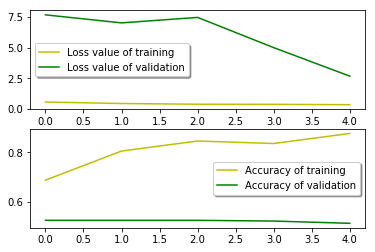

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='y', label="Loss value of training")
ax[0].plot(history.history['val_loss'], color='g', label="Loss value of validation",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='y', label="Accuracy of training")
ax[1].plot(history.history['val_acc'], color='g',label="Accuracy of validation")
legend = ax[1].legend(loc='best', shadow=True)

Following is our prediction:


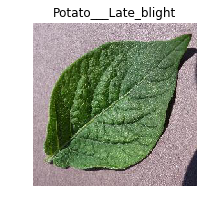

In [10]:
# predicting an image
from keras.preprocessing import image
import numpy as np
#image_path = "potato1/test/Potato___healthy/c6204cb3-cd9f-4d7b-92a6-9773fe562cab___RS_HL 1939.JPG"
image_path = "potato1/test/Potato___Late_blight/3112e625-f1d9-428b-a77e-23c6f28e44f8___RS_LB 3035.JPG"
new_img = image.load_img(image_path, target_size=(256,256),color_mode='rgb')
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

##Another way
# img_class = classifier.predict_classes(img)
# img_prob = classifier.predict_proba(img)
# print(img_class ,img_prob )


#ploting image with predicted class name        
plt.figure(figsize = (3,3))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

In [18]:
from sklearn.metrics import classification_report
Y_pred = model.predict_generator(valid_set, 330/33)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_set.classes, y_pred))
print('Classification Report')
target_names = ['Potato___healthy','Potato___Late_blight']
print(classification_report(valid_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[169   4]
 [155   2]]
Classification Report
                      precision    recall  f1-score   support

    Potato___healthy       0.52      0.98      0.68       173
Potato___Late_blight       0.33      0.01      0.02       157

           micro avg       0.52      0.52      0.52       330
           macro avg       0.43      0.49      0.35       330
        weighted avg       0.43      0.52      0.37       330



ModuleNotFoundError: No module named 'intertools'

NameError: name 'itertools' is not defined

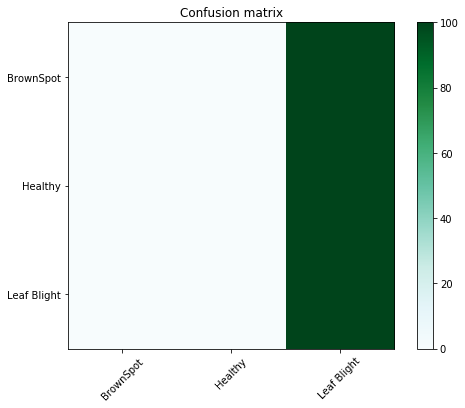

In [9]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
  
   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(confusion_matrix(valid_set.classes, y_pred), target_names = ['BrownSpot','Healthy','Leaf Blight'],cmap='BuGn') 


In [31]:
from PIL import Image 
  
filename = "potato/test/healthy.JPG"
with Image.open(filename) as image: 
    width, height = image.size 
#Image.size gives a 2-tuple and the width, height can be obtained 

In [32]:
img = Image.open("potato/test/healthy.JPG")  
          
        #In-place modification 
        img.thumbnail((200, 200))  

IndentationError: unexpected indent (<ipython-input-32-b65ba26b2cb8>, line 4)

In [ ]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()